# Easy (+0.1)

In [50]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

#preparing data
data = pd.read_pickle('..\\data\\train.pickle')
description = pd.read_csv('..\\data\\label_names.csv').SignName

x = data['features']
y = data['labels']

x = x / 255.0

x_reshaped = x.reshape((x.shape[0], -1))

#0.6 ration seem to be optimal (scroll to bottom nodes)
x_train, x_test, y_train, y_test = train_test_split(x_reshaped, y, test_size=0.4, random_state=42)

print(f'Training dataset size: {len(x_train)}')

Training dataset size: 20879


In [51]:
#model training 
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Accuracy: 0.9458531120284157
Training dataset size: 20879
Testing dataset size: 13920


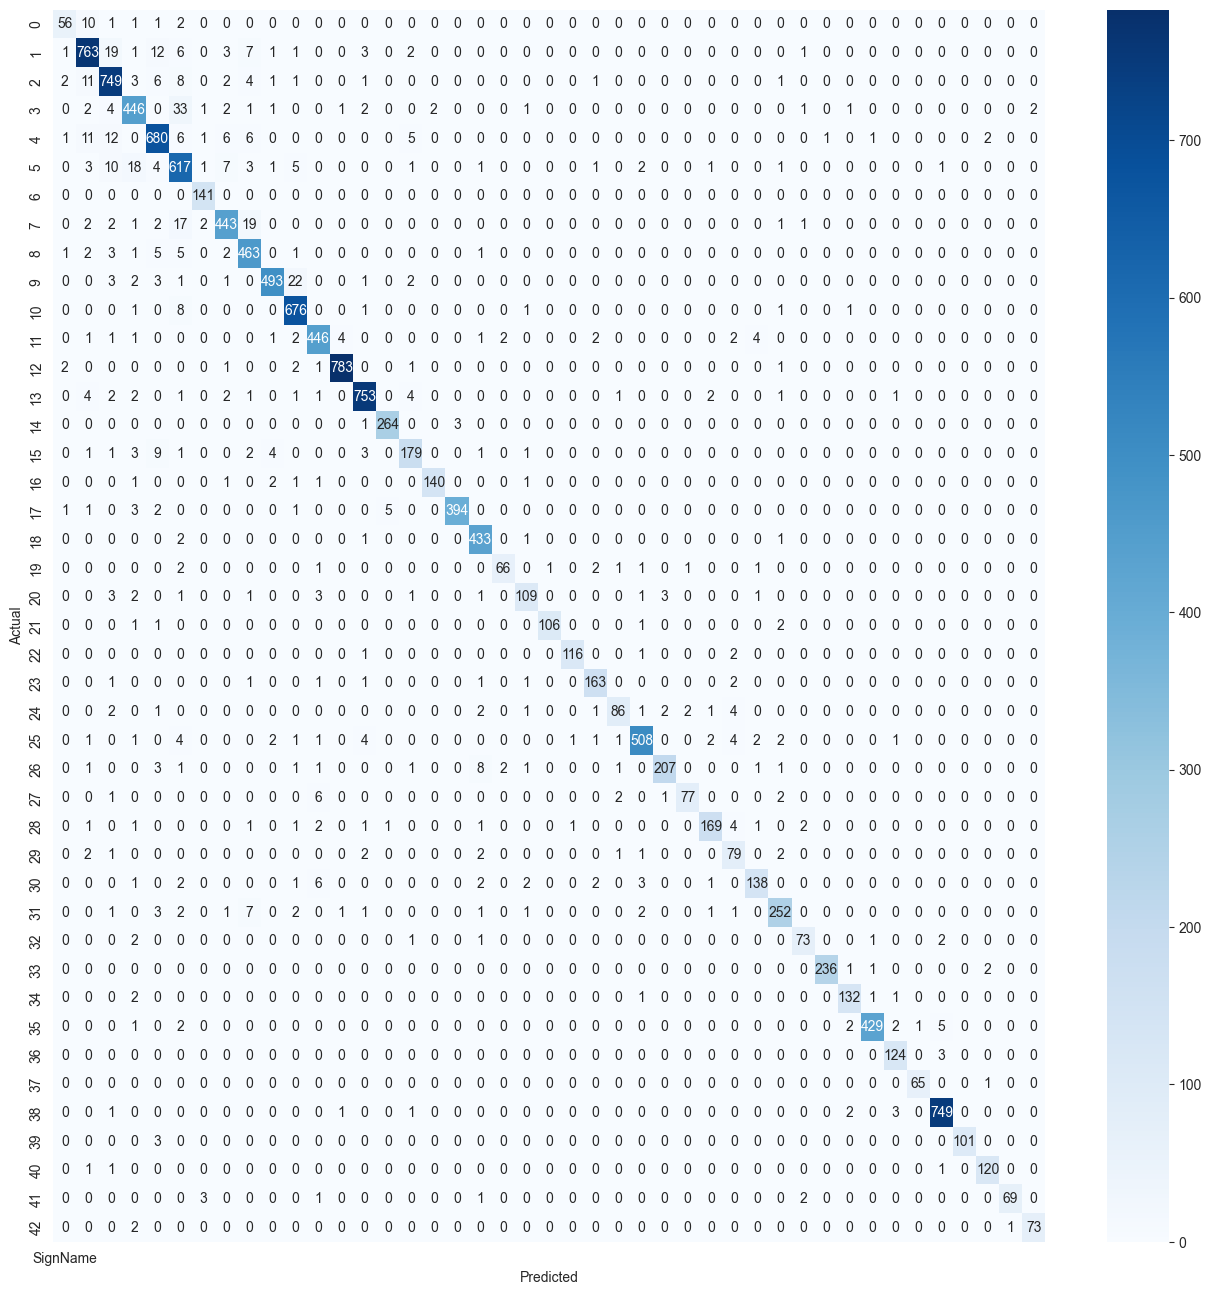

In [52]:
import seaborn as sns
from sklearn.metrics import f1_score


# result visualizing
def show_accuracy(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(16, 16))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['SignName'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


y_pred = model.predict(x_test)

accuracy = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy: {accuracy}')

print(f'Training dataset size: {len(x_train)}')
print(f'Testing dataset size: {len(x_test)}')

conf_matrix = confusion_matrix(y_test, y_pred)

show_accuracy(y_test, y_pred)

In [53]:
dct = dict()

for i in range(len(conf_matrix)):
    err_number = 0
    for j in range(len(conf_matrix[i])):
        if i != j:
            err_number += conf_matrix[i][j]
    dct[description[i]] = err_number

sorted_keys = [key for key, value in sorted(dct.items(), key=lambda item: item[1], reverse=True)[:7]]
print(sorted_keys)

['Speed limit (80km/h)', 'Speed limit (30km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (100km/h)', 'Speed limit (50km/h)', 'No passing']


##### First of all, I have trained a Logistic Regression model on half of the dataset (Assuming that optimal size will be approximately 50% of all entities). I've chose f1-metric. The “weighted” alteration mitigates the flaws of “micro” and “macro” presets since it takes into account the number of samples of each class. The model confuses signs of speed limits due to their similarity: the main difference is the text of the sign, which may not be properly recognized because of poor image quality

# Medium (+0.4)

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import f1_score

import time

#comapraing models

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'kNN': KNeighborsClassifier(n_neighbors=3),
    'Naive Bayes': GaussianNB(),
    'SVM Linear': SVC(kernel='linear', random_state=42),
    'SVM Polynomial': SVC(kernel='poly', degree=3, random_state=42),
    'SVM RBF': SVC(kernel='rbf', random_state=42)
}

results = {}

for name, model in models.items():
    t1 = time.time()
    model.fit(x_train, y_train)
    t2 = time.time()

    y_pred = model.predict(x_test)

    accuracy = f1_score(y_test, y_pred, average='weighted')
    results[name] = accuracy

    print(f'{name}: \n\tAccuracy: {accuracy} \n\tTime: {t2 - t1}')

best_model = max(results, key=results.get)
worst_model = min(results, key=results.get)

print(f'Best: {best_model} with precision {results[best_model]}')
print(f'Worst: {worst_model} with precision {results[worst_model]}')

Logistic Regression: 
	Accuracy: 0.9458531120284157 
	Time: 33.393218755722046
kNN: 
	Accuracy: 0.8747858665882648 
	Time: 0.06632804870605469
Naive Bayes: 
	Accuracy: 0.16918700564747327 
	Time: 0.46033406257629395
SVM Linear: 
	Accuracy: 0.951472736543386 
	Time: 66.67044043540955
SVM Polynomial: 
	Accuracy: 0.7292569637416413 
	Time: 182.39869570732117
SVM RBF: 
	Accuracy: 0.8518448082838214 
	Time: 228.80292797088623
Best: SVM Linear with precision 0.951472736543386
Worst: Naive Bayes with precision 0.16918700564747327


##### NBC appeared to be the worst model while Logistic Regression appeared to be the most suitable. It is applicable in scenarios, where features are independent. Image classification task does not meet this requirement as:
##### 1) Road sign can be recognised by a small part of the whole image
##### 2) Low resolution and noticeable blurring effect makes neighboring pixel colors similar, binding them.

# Logistic Regression optimal training dataset size estimation:

In [55]:
import matplotlib.pyplot as plt
import time

results = []
min_train_percentage = 30
max_train_percentage = 80
step = 10

print(f'Total dataset size: {len(x)}')

for fraction in range(min_train_percentage, max_train_percentage, step):
    ratio = fraction / 100

    x_train, x_test, y_train, y_test = train_test_split(x_reshaped, y, test_size=1 - ratio, random_state=42)
    print(f'Ratio = {ratio}')

    t1 = time.time()
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(x_train, y_train)
    t2 = time.time()

    print(f'\tTime: {t2 - t1} seconds\n\tTraining dataset size: {len(x_train)}')

    y_pred = model.predict(x_test)
    accuracy = f1_score(y_test, y_pred, average='weighted')

    results.append((fraction, accuracy))

Total dataset size: 34799
Ratio = 0.3
	Time: 14.471723556518555 seconds
	Training dataset size: 10439
Ratio = 0.4
	Time: 24.23367738723755 seconds
	Training dataset size: 13919
Ratio = 0.5
	Time: 31.025992393493652 seconds
	Training dataset size: 17399
Ratio = 0.6
	Time: 33.162845849990845 seconds
	Training dataset size: 20879
Ratio = 0.7
	Time: 44.866938829422 seconds
	Training dataset size: 24359


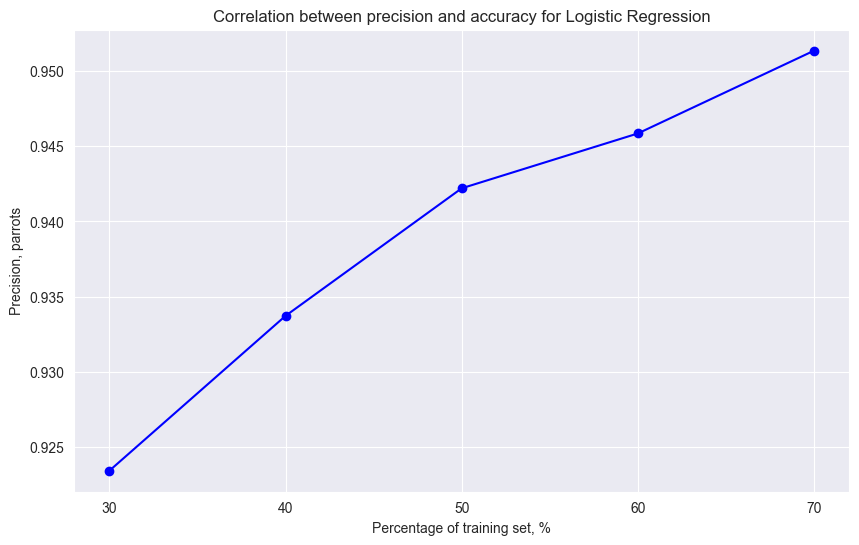

In [56]:
ratio, accuracies = zip(*results)

plt.figure(figsize=(10, 6))
plt.plot(ratio, accuracies, marker='o', linestyle='-', color='b')
plt.title('Correlation between precision and accuracy for Logistic Regression')
plt.xlabel('Percentage of training set, %')
plt.ylabel('Precision, parrots')
plt.grid(True)
plt.xticks(range(min_train_percentage, max_train_percentage, step))
plt.show()